In [2]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats
from scipy.stats import norm

import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go

from sklearn import datasets, linear_model
import copy

# import EV_chargingstation_planning_inputdata_l2 as ECPinput
import cvxpy as cvx
import pdb

In [3]:
def load_chargePoint_data(filename, wantzero=True):
    """
        Load charge point data into python
        filename - string, specify file name
        wantzero - boolean, specify if want to keep zero energy sessions in data
    """
    
    df = pd.read_csv(filename)
    # Columns of information that exists in the csv file
    print("dataframe column: ")
    print(df.columns)
    
    # Extract columns that we are interested in
    cp_df = df[["MAC Address", "Start Date", "End Date", "User ID", "Energy (kWh)", 
                "Port Type", "Total Duration (hh:mm:ss)", "Charging Time (hh:mm:ss)"]]
    
    cp_len = len(cp_df)
    if not wantzero:
        
        # Delete zero entries
        cp_df = cp_df[(cp_df != 0).all(1)]
        print("\n")
        print("Deleted {} zero entries.".format(cp_len - len(cp_df)))
        
    else:
        
        # Fix NaN entries in End Date
        nan_number = 0
        for indx, row in cp_df.iterrows():
            if pd.isna(cp_df.loc[indx, "End Date"]):
                if not pd.isna(cp_df.loc[indx, "Start Date"]):

                    endDate = pd.to_datetime(cp_df.loc[indx, "Start Date"]) + \
                    pd.to_timedelta(cp_df.loc[indx, "Total Duration (hh:mm:ss)"])

                    cp_df.at[indx, "End Date"] = str(endDate)

                    nan_number += 1
        print("\n")
        print("Fixed {} NaN values".format(nan_number))
    
    return cp_df 

In [4]:
csv_file = 'chargpoint_0116_0123_Data.csv'
cp_df = load_chargePoint_data(csv_file, wantzero=False)
cp_df

dataframe column: 
Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone',
       'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)',
       'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Address 1', 'Address 2', 'City', 'State/Province',
       'Postal Code', 'Country', 'Latitude', 'Longitude', 'Currency', 'Fee',
       'Ended By', 'Plug In Event Id', 'Driver Postal Code', 'User ID',
       'Start SOC', 'End SOC', 'County', 'System S/N', 'Model Number'],
      dtype='object')


Deleted 17 zero entries.


,MAC Address,Start Date,End Date,User ID,Energy (kWh),Port Type,Total Duration (hh:mm:ss),Charging Time (hh:mm:ss)
0,0024:B100:0002:1302,2019-01-23 12:00:51,2019-01-23 13:29:13,3334181.0,10.086,Level 2,01:28:22,01:27:09
1,0024:B100:0002:2342,2019-01-23 09:09:17,2019-01-23 13:18:51,1248301.0,6.074,Level 2,04:09:34,01:54:09
2,0024:B100:0002:12F1,2019-01-23 09:53:48,2019-01-23 13:10:55,385681.0,2.857,Level 2,03:17:07,00:25:29
3,0024:B100:0002:2010,2019-01-23 09:04:24,2019-01-23 13:09:00,349725.0,4.513,Level 2,04:04:35,01:27:49
4,0024:B100:0002:12F1,2019-01-23 09:22:13,2019-01-23 13:08:10,710899.0,3.475,Level 2,03:46:00,03:45:48
5,0024:B100:0002:1302,2019-01-23 08:10:41,2019-01-23 12:27:17,1260731.0,7.921,Level 2,04:16:36,02:09:42
6,0024:B100:0002:2010,2019-01-23 09:57:41,2019-01-23 11:48:23,1669191.0,11.426,Level 2,01:50:40,01:50:31
7,0024:B100:0002:1302,2019-01-23 07:44:21,2019-01-23 11:40:02,827095.0,11.658,Level 2,03:55:41,03:25:42
8,0024:B100:0002:2342,2019-01-23 07:58:36,2019-01-23 11:33:53,711871.0,6.459,Level 2,03:35:15,03:35:05
9,0024:B100:0002:1280,2019-01-23 09:10:22,2019-01-23 11:14:04,3575341.0,4.175,Level 2,02:03:42,01:21:15


# Data visualization

In [5]:
x_data_chargeTime = pd.to_timedelta(cp_df["Charging Time (hh:mm:ss)"]).dt.total_seconds()
y_data_energy = pd.to_numeric(cp_df["Energy (kWh)"])

## Charging Duration

Text(0, 0.5, 'Frequency')

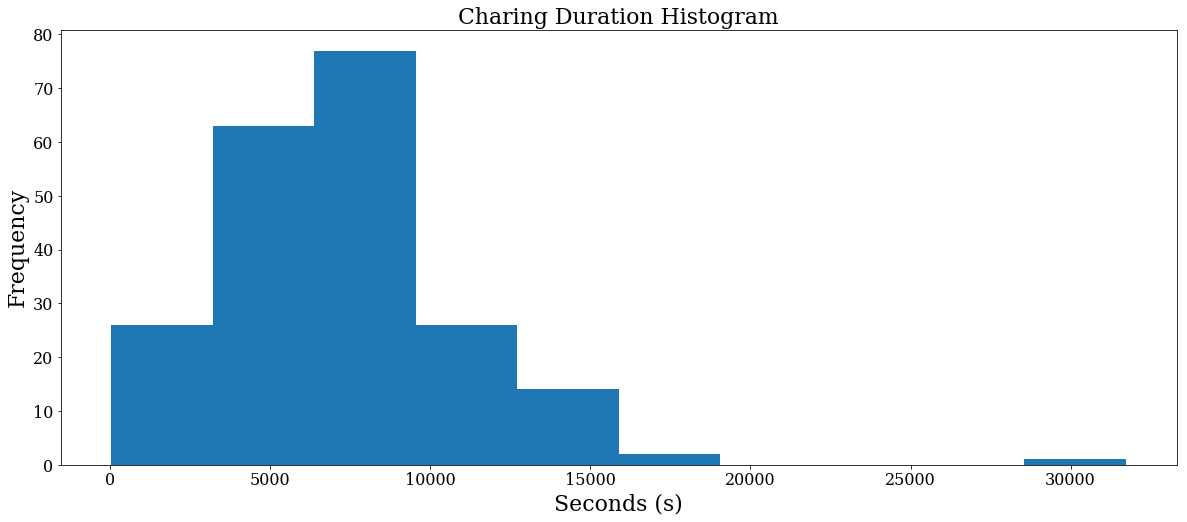

In [16]:
font = {'family' : 'serif',
        'size'   : 16}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(20,8))
plt.hist(x_data_chargeTime)
plt.title("Charing Duration Histogram", fontsize=22)
plt.xlabel("Seconds (s)", fontsize=22)
plt.ylabel("Frequency", fontsize=22)


# plotly_fig = tls.mpl_to_plotly( fig )
# py.iplot(plotly_fig, filename='mpl-basic-histogram')


## Session Length - Load data from CP database directly

Text(0, 0.5, 'Cumulative Percentage (%)')

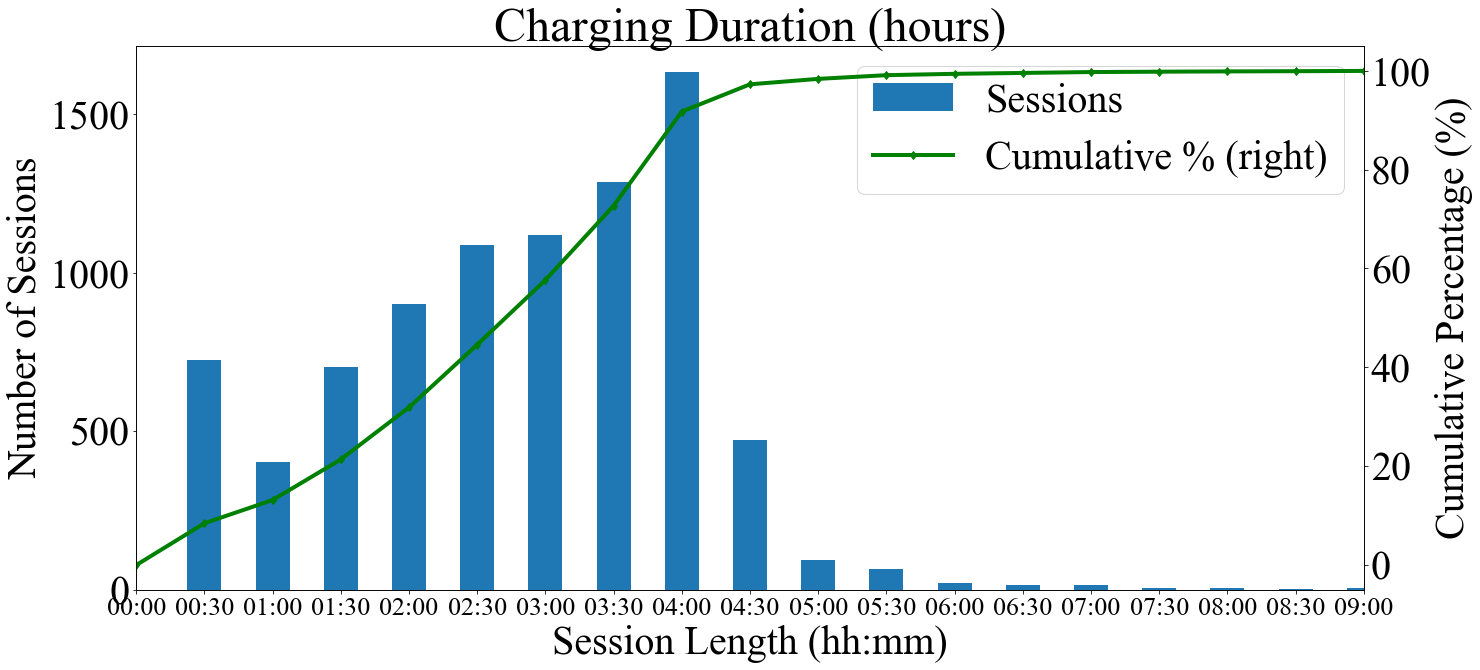

In [31]:
sl_df = pd.read_csv("session_length.csv") #plot data download directly from CP
sl_df = sl_df.iloc[:19, :]
ax = sl_df.plot.bar(x="Session Length (hh:mm)", y="Sessions", figsize=(22,10))
ax.set_xticklabels(sl_df["Session Length (hh:mm)"], fontsize=26)
ax.set_ylabel("Number of Sessions")
ax.set_title("Charging Duration (hours)")

ax2 = sl_df.plot.line(x="Session Length (hh:mm)", y="Cumulative %", 
                ax=ax, marker="d", linewidth=4, color="g", secondary_y=True)
ax2.set_ylabel("Cumulative Percentage (%)")
# plt.savefig("output_figures/session_length_CP.pdf")

## EV Market Shares - Essencially we need weighted average battery sizes of 7.2 and 3.6 EVs

In [9]:
ev_sales_df = pd.read_excel("ev_historicalSales.xlsx",index_col=0)

In [10]:
ev_sales_df

,2018,2017,2016,2015,2014,Total Sales,Charging Power (kW),Battery (kWh),Total Battery (kWh)
Tesla Model 3,13782,1764,0,0,0,15546,7.2,50.000000,7.773000e+05
Toyota Prius Prime + PHEV,27595,20936,2474,4191,13264,68460,3.6,7.674806,5.254172e+05
Tesla Model X,26100,21315,18223,214,0,65852,7.2,75.000000,4.938900e+06
Tesla Model S,25745,27060,28896,25202,16689,123592,7.2,70.000000,8.651440e+06
Honda Clarity PHEV,18602,1121,0,0,0,19723,7.2,25.500000,5.029365e+05
Chevy Volt,18306,20349,24739,15393,18805,97592,3.6,18.400000,1.795693e+06
Chevy Bolt,18019,23297,579,0,0,41895,7.2,60.000000,2.513700e+06
Nissan Leaf,14715,11230,14006,17269,30200,87420,7.2,35.000000,3.059700e+06
Ford Fusion Energi,8074,9632,15938,9750,11550,54944,3.6,7.600000,4.175744e+05
Ford C-max Energi,582,8140,7957,7591,8433,32703,3.6,7.600000,2.485428e+05


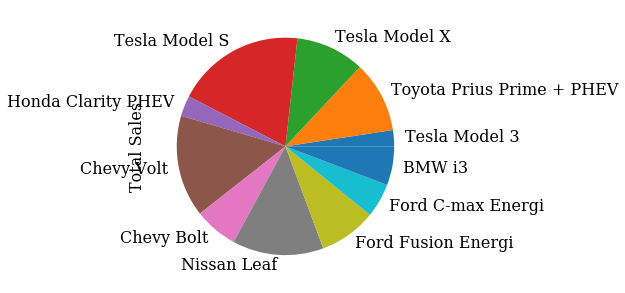

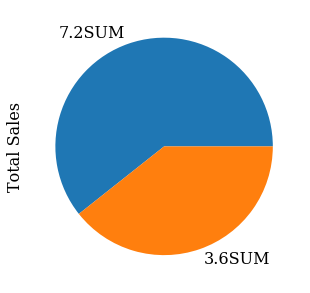

In [11]:
font = {'family' : 'serif',
        'size'   : 16}

matplotlib.rc('font', **font)
ev_sales_df.iloc[:-2,:].plot.pie(y="Total Sales", figsize=(5,5), legend=False)
ev_sales_df.loc[["7.2SUM", "3.6SUM"],:].plot.pie(y="Total Sales", figsize=(5,5), legend=False)

# Quantile Regression

In [12]:
x_data_chargeTime_copy = copy.deepcopy(x_data_chargeTime)
y_data_energy_copy = copy.deepcopy(y_data_energy)

x_data_chargeTime_copy = x_data_chargeTime_copy.dropna()
y_data_energy_copy = y_data_energy_copy.dropna()

x_data_chargeTime_copy = x_data_chargeTime_copy.values
y_data_energy_copy = y_data_energy_copy.values

In [17]:
font = {'family' : 'serif',
        'size'   : 20}

matplotlib.rc('font', **font)

def quantile_regression(x_data, y_data, q_list, loc, comments):
    """
        From charging rates extract quantile and perform linear regression
        x_data - numpy array
        y_data - numpy array
        q_list - list of quantiles, [0, 100]
        loc - list of boolean, specify the needed data is above the percentile of below the percentile
                True for above
        comments - list of string, for extra comments on legends
    """
    plt.figure(figsize=(20,8))
    
    charge_rate_list = y_data / x_data
    
    loc_word = ["above", "below"]
    
    
    for idx, q in enumerate(q_list):
        
        if loc[idx]:
            # Select values that are above specified quantile
            x_data_q = x_data[np.where(charge_rate_list > np.percentile(charge_rate_list, q))]
            y_data_q = y_data[np.where(charge_rate_list > np.percentile(charge_rate_list, q))]
            loc_idx = 0
        
        else:
            x_data_q = x_data[np.where(charge_rate_list < np.percentile(charge_rate_list, q))]
            y_data_q = y_data[np.where(charge_rate_list < np.percentile(charge_rate_list, q))]
            loc_idx = 1
            
        # Create linear regression object
        regr = linear_model.LinearRegression()

        # Train the model using the training sets
        regr.fit(x_data_q.reshape(-1,1), y_data_q.reshape(-1,1))
        
        # The coefficients
        print("Coefficients: " + str(regr.coef_[0,0]) + ", {} {} percentile.".format(loc_word[loc_idx], q))
    
        # Plot regression line
        # plt.scatter(x_data, y_data)
        x_regr = np.linspace(0, 34000, 1000).reshape(-1,1)
        y_regr = regr.predict(x_regr)
        if comments[idx] == "":
            plt.plot(x_regr, y_regr, label="{} {} Percentile Regression Line, Coef={}".format(loc_word[loc_idx], 
                                                                                              q, round(regr.coef_[0,0], 7)))
        else:
            plt.plot(x_regr, y_regr, label="{} {} Percentile Regression Line, Coef={}, ".format(loc_word[loc_idx], 
                                                                                                q, round(regr.coef_[0,0], 7)) + comments[idx])

    # Plot original data
    plt.scatter(x_data, y_data, label="Original Data")
    plt.legend(fontsize=16)
    plt.xlabel("Seconds (s)")
    plt.ylabel("Energy Consumption (kwh)")
    plt.show()

Coefficients: 0.0005231918827516106, below 15 percentile.
Coefficients: 0.0009540908267482915, below 80 percentile.
Coefficients: 0.0016114006387577806, above 50 percentile.
Coefficients: 0.0019497005442590178, above 90 percentile.


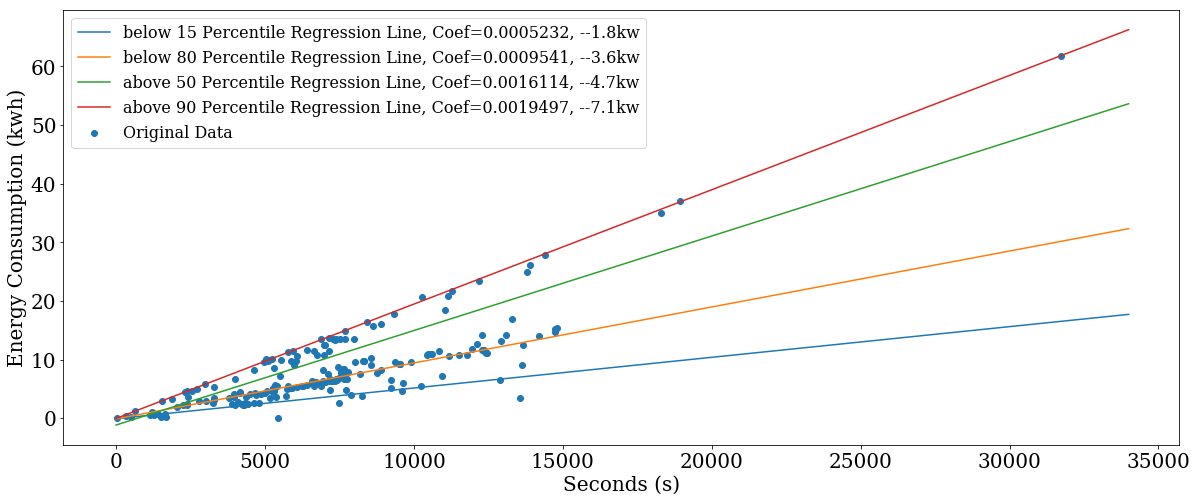

In [18]:
quantile_regression(x_data_chargeTime_copy, y_data_energy_copy, q_list=[15, 80, 50, 90], 
                    loc=[False, False, True, True], comments=["--1.8kw", "--3.6kw", "--4.7kw", "--7.1kw"])

# Idle time

In [19]:
idleTime_list = pd.to_timedelta(cp_df["Total Duration (hh:mm:ss)"]).dt.total_seconds() \
- pd.to_timedelta(cp_df["Charging Time (hh:mm:ss)"]).dt.total_seconds().values
idlegap = 3600

In [20]:
x_data_copy_idle = x_data_chargeTime_copy[np.where(idleTime_list > idlegap)]
y_data_copy_idle = y_data_energy_copy[np.where(idleTime_list > idlegap)]

Coefficients: 0.0019523642183000606, above 90 percentile.
Coefficients: 0.0011131472948956564, below 70 percentile.


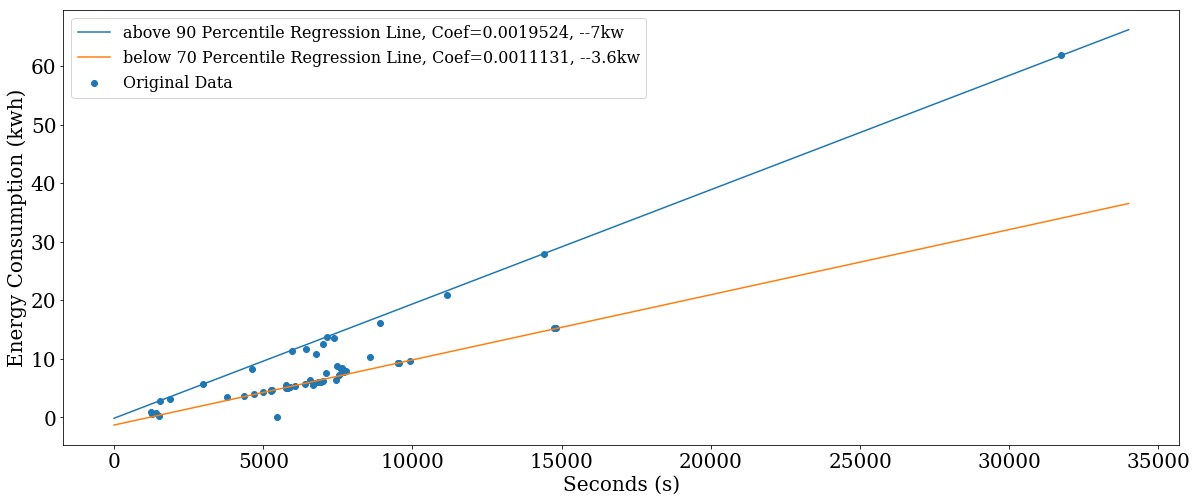

In [21]:
quantile_regression(x_data_copy_idle, y_data_copy_idle, [90, 70], [True, False], ["--7kw", "--3.6kw"])

# Aggregate Demands

In [22]:
csv_file = 'chargpoint_0116_0123_Data.csv'
cp_df = load_chargePoint_data(csv_file, wantzero=True)

dataframe column: 
Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone',
       'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)',
       'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Address 1', 'Address 2', 'City', 'State/Province',
       'Postal Code', 'Country', 'Latitude', 'Longitude', 'Currency', 'Fee',
       'Ended By', 'Plug In Event Id', 'Driver Postal Code', 'User ID',
       'Start SOC', 'End SOC', 'County', 'System S/N', 'Model Number'],
      dtype='object')


Fixed 9 NaN values


In [23]:
# Take daylight saving into acount and leave out rows that erroneous
cp_df = cp_df.loc[pd.to_timedelta(cp_df["Total Duration (hh:mm:ss)"]) + dt.timedelta(hours=1) > \
                  pd.to_timedelta(pd.to_datetime(cp_df["End Date"]) - pd.to_datetime(cp_df["Start Date"]))]

In [24]:
cp_df

,MAC Address,Start Date,End Date,User ID,Energy (kWh),Port Type,Total Duration (hh:mm:ss),Charging Time (hh:mm:ss)
0,0024:B100:0002:1302,2019-01-23 12:00:51,2019-01-23 13:29:13,3334181.0,10.086,Level 2,01:28:22,01:27:09
1,0024:B100:0002:2342,2019-01-23 09:09:17,2019-01-23 13:18:51,1248301.0,6.074,Level 2,04:09:34,01:54:09
2,0024:B100:0002:12F1,2019-01-23 09:53:48,2019-01-23 13:10:55,385681.0,2.857,Level 2,03:17:07,00:25:29
3,0024:B100:0002:2010,2019-01-23 09:04:24,2019-01-23 13:09:00,349725.0,4.513,Level 2,04:04:35,01:27:49
4,0024:B100:0002:12F1,2019-01-23 09:22:13,2019-01-23 13:08:10,710899.0,3.475,Level 2,03:46:00,03:45:48
5,0024:B100:0002:1302,2019-01-23 08:10:41,2019-01-23 12:27:17,1260731.0,7.921,Level 2,04:16:36,02:09:42
6,0024:B100:0002:2010,2019-01-23 09:57:41,2019-01-23 11:48:23,1669191.0,11.426,Level 2,01:50:40,01:50:31
7,0024:B100:0002:1302,2019-01-23 07:44:21,2019-01-23 11:40:02,827095.0,11.658,Level 2,03:55:41,03:25:42
8,0024:B100:0002:2342,2019-01-23 07:58:36,2019-01-23 11:33:53,711871.0,6.459,Level 2,03:35:15,03:35:05
9,0024:B100:0002:1280,2019-01-23 09:10:22,2019-01-23 11:14:04,3575341.0,4.175,Level 2,02:03:42,01:21:15


## Before aggregating: Utilization, duration, and session length

In [27]:
# extract data and plot data through caluclation
cp_df_2018_2019 = cp_df[pd.to_datetime(cp_df["Start Date"]) > dt.datetime(2019, 1, 15)]

In [28]:
tot_plugInLength = pd.to_timedelta(cp_df_2018_2019["Total Duration (hh:mm:ss)"]).sum()  #total plug in length
tot_chargingLength = pd.to_timedelta(cp_df_2018_2019["Charging Time (hh:mm:ss)"]).sum() #total charging length
actual_charging_rate = tot_chargingLength/tot_plugInLength
utilization_rate = tot_chargingLength.total_seconds()/(dt.datetime(2019,1,23) - dt.datetime(2015,3,26)).total_seconds()/12
print("The charging over parking ratio is: ", actual_charging_rate, ", due to CP is implementing pricing policy.")
print("The utilization rate is: ", utilization_rate, ", from 2019.1.16 to 2019.1.23.")

The charging over parking ratio is:  0.7372148232393542 , due to CP is implementing pricing policy.
The utilization rate is:  0.001033211553225849 , from 2019.1.16 to 2019.1.23.


### Total Duration

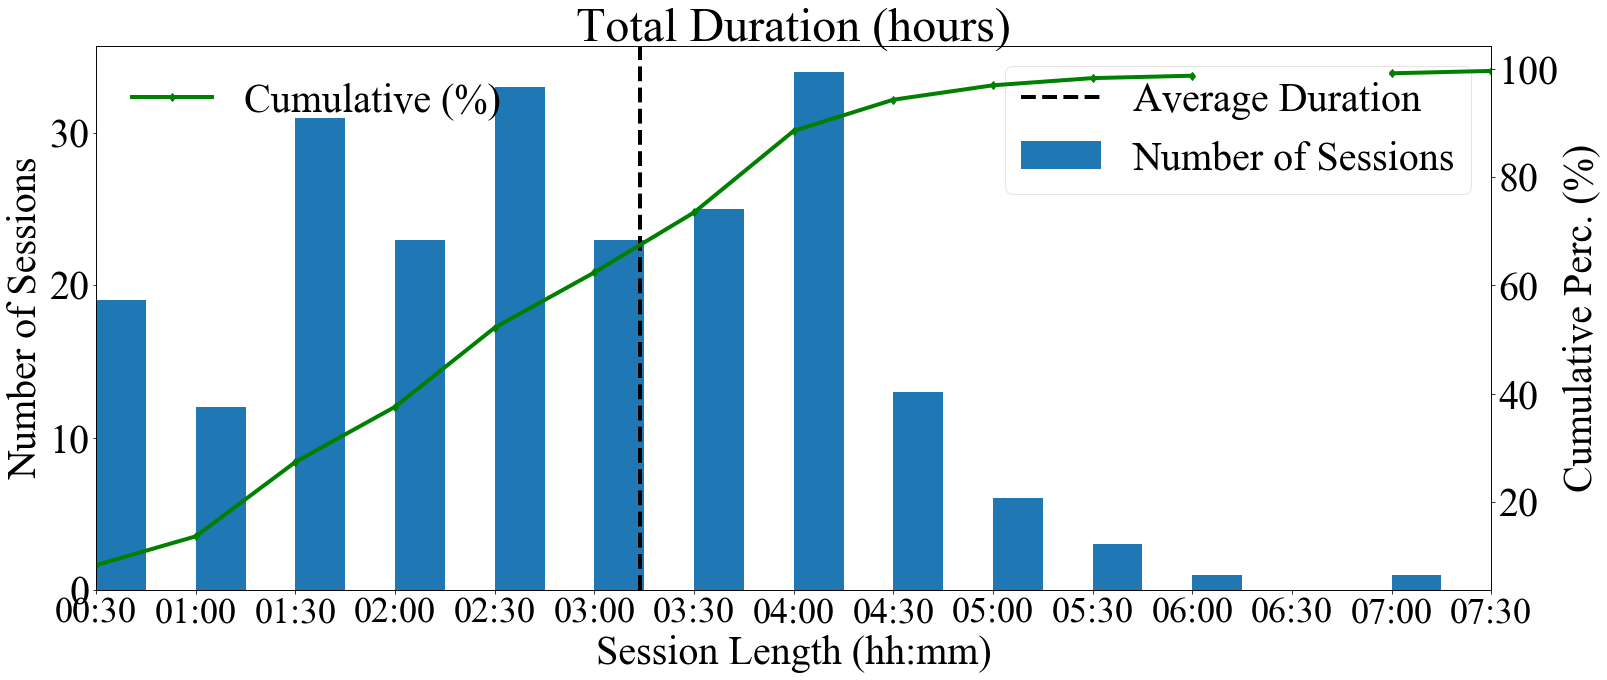

In [32]:
test = np.ceil(pd.to_timedelta(cp_df_2018_2019["Total Duration (hh:mm:ss)"]).dt.total_seconds()/1800).value_counts()
test = test.sort_index(axis=0)
test_df = pd.concat([(100*test.cumsum()/test.sum())[:15], test[:15], sl_df["Session Length (hh:mm)"][1:16]], axis=1)
test_df.columns = ["Cumulative Percentage (%)", "Number of Sessions", "Session Length (hh:mm)"]

# set up plot specs
font = {'family' : 'Times New Roman',
        'size'   : 40}

matplotlib.rc('font', **font)
# average duration length
ave_duration = (test_df["Number of Sessions"]*test_df.index).sum()/test_df["Number of Sessions"].sum()

# plot results
ax = test_df.plot.bar(x="Session Length (hh:mm)", y="Number of Sessions", \
                      figsize=(25, 10), align="edge")
# plot average duration line
ax.axvline(ave_duration, color='k', linestyle='--', linewidth=4, label="Average Duration")
# plot cumulative percentage
ax.set_xticklabels(test_df["Session Length (hh:mm)"], fontsize=36)
ax.set_ylabel("Number of Sessions")
ax.set_title("Total Duration (hours)")

ax2 = test_df.plot.line(x="Session Length (hh:mm)", y="Cumulative Percentage (%)", 
                ax=ax, marker="d", linewidth=4, color="g", secondary_y=True, 
                        label="Cumulative (%)")
ax2.set_ylabel("Cumulative Perc. (%)")
ax.legend(loc="best", framealpha=0.5)
ax2.legend(loc="best", framealpha=0)
# plt.savefig("output_figures/session_total_duration_calc.pdf")

### Charging Duration

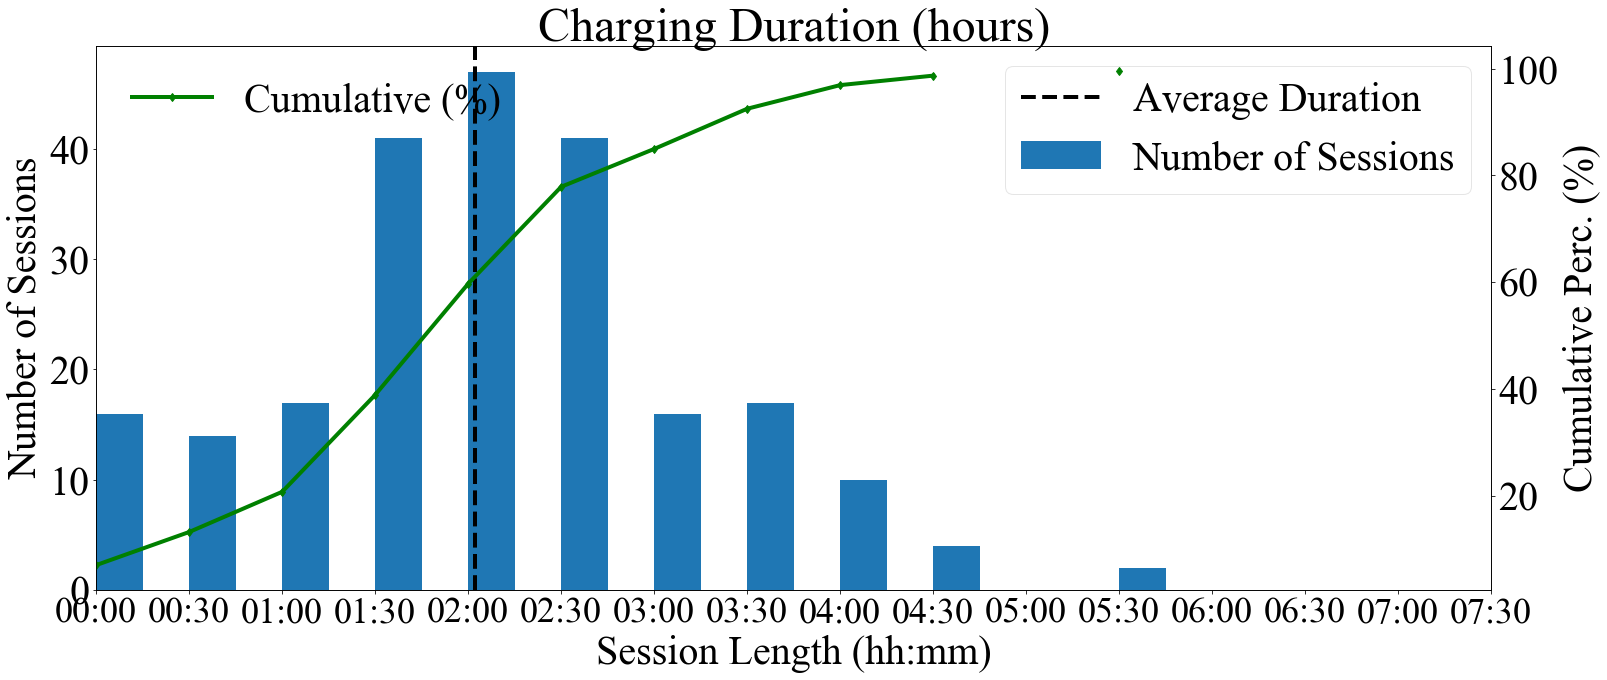

In [33]:
test = np.ceil(pd.to_timedelta(cp_df_2018_2019["Charging Time (hh:mm:ss)"]).dt.total_seconds()/1800).value_counts()
test = test.sort_index(axis=0)
test_df = pd.concat([(100*test.cumsum()/test.sum())[:15], test[:15], sl_df["Session Length (hh:mm)"][:16]], axis=1)
test_df.columns = ["Cumulative Percentage (%)", "Number of Sessions", "Session Length (hh:mm)"]

# set up plot specs
font = {'family' : 'Times New Roman',
        'size'   : 40}

matplotlib.rc('font', **font)
# average duration length
ave_duration = (test_df["Number of Sessions"]*test_df.index).sum()/test_df["Number of Sessions"].sum()

# plot results
ax = test_df.plot.bar(x="Session Length (hh:mm)", y="Number of Sessions", \
                      figsize=(25, 10), align="edge")
# plot average duration line
ax.axvline(ave_duration, color='k', linestyle='--', linewidth=4, label="Average Duration")
# plot cumulative percentage
ax.set_xticklabels(test_df["Session Length (hh:mm)"], fontsize=36)
ax.set_ylabel("Number of Sessions")
ax.set_title("Charging Duration (hours)")

ax2 = test_df.plot.line(x="Session Length (hh:mm)", y="Cumulative Percentage (%)", 
                ax=ax, marker="d", linewidth=4, color="g", secondary_y=True, 
                        label="Cumulative (%)")
ax2.set_ylabel("Cumulative Perc. (%)")
ax.legend(loc="best", framealpha=0.5)
ax2.legend(loc="best", framealpha=0)
# plt.savefig("output_figures/session_charging_duration_calc.pdf")

# Create daily profile

In [34]:
cp_df

,MAC Address,Start Date,End Date,User ID,Energy (kWh),Port Type,Total Duration (hh:mm:ss),Charging Time (hh:mm:ss)
0,0024:B100:0002:1302,2019-01-23 12:00:51,2019-01-23 13:29:13,3334181.0,10.086,Level 2,01:28:22,01:27:09
1,0024:B100:0002:2342,2019-01-23 09:09:17,2019-01-23 13:18:51,1248301.0,6.074,Level 2,04:09:34,01:54:09
2,0024:B100:0002:12F1,2019-01-23 09:53:48,2019-01-23 13:10:55,385681.0,2.857,Level 2,03:17:07,00:25:29
3,0024:B100:0002:2010,2019-01-23 09:04:24,2019-01-23 13:09:00,349725.0,4.513,Level 2,04:04:35,01:27:49
4,0024:B100:0002:12F1,2019-01-23 09:22:13,2019-01-23 13:08:10,710899.0,3.475,Level 2,03:46:00,03:45:48
5,0024:B100:0002:1302,2019-01-23 08:10:41,2019-01-23 12:27:17,1260731.0,7.921,Level 2,04:16:36,02:09:42
6,0024:B100:0002:2010,2019-01-23 09:57:41,2019-01-23 11:48:23,1669191.0,11.426,Level 2,01:50:40,01:50:31
7,0024:B100:0002:1302,2019-01-23 07:44:21,2019-01-23 11:40:02,827095.0,11.658,Level 2,03:55:41,03:25:42
8,0024:B100:0002:2342,2019-01-23 07:58:36,2019-01-23 11:33:53,711871.0,6.459,Level 2,03:35:15,03:35:05
9,0024:B100:0002:1280,2019-01-23 09:10:22,2019-01-23 11:14:04,3575341.0,4.175,Level 2,02:03:42,01:21:15


In [35]:
def extract_dayData(month, day):
    """
        Extract day utilization data from specified day range
        Note: this function extract data from three years
                so only month and day numbers are needed 
        day_start, day_end - datetime object
    """
    
    years_list = [2019]
    df_tmp = list()
    
    for y in range(len(years_list)):
        
        day_start = dt.datetime(years_list[y], month, day)
        day_end = day_start + dt.timedelta(days=1)

        df_tmp.append(cp_df.loc[(pd.to_datetime(cp_df["Start Date"])>day_start) \
                            & (pd.to_datetime(cp_df["Start Date"])<day_end)])
    
    return pd.concat(df_tmp)

In [36]:
# def datetime2dayidx(starttime, endtime):
#     """
#         Compute tick point index of the day based on the input time
#         Using both datetime objects to determine if EV stays overnight
#         starttime, endtime - datetime object
#     """
# #     if starttime.minute < 30:
# #         starttime_idx = starttime.hour*4 
# #     else:
# #         starttime_idx = starttime.hour*4 + 2
# #     if endtime.minute < 30:
# #         endtime_idx = endtime.hour*4 + 2
# #     else:
# #         endtime_idx = endtime.hour*4 + 4
    
#     if starttime.hour == endtime.hour:
#         starttime_idx = starttime.hour*4
#         endtime_idx = endtime.hour*4+2
#     elif starttime.hour == endtime.hour-1:
#         starttime_idx = starttime.hour*4
#         endtime_idx = endtime.hour*4
#     else:
#         starttime_idx = starttime.hour*4+2
#         endtime_idx = endtime.hour*4
        
#     if starttime.hour > endtime.hour:
#         return starttime_idx, endtime_idx+96
#     else:
#         return starttime_idx, endtime_idx

def datetime2dayidx(starttime, endtime):
    """
        Compute tick point index of the day based on the input time
        Using both datetime objects to determine if EV stays overnight
        starttime, endtime - datetime object
    """
    def datetime2dayidx_helper(time):
        if time.minute < 7.5:
            extra_tick = 0
        elif (time.minute > 7.5) & (time.minute < 22.5):
            extra_tick = 1
        elif (time.minute > 22.5) & (time.minute < 37.5):
            extra_tick = 2
        elif (time.minute > 37.5) & (time.minute < 52.5):
            extra_tick = 3
        else:
            extra_tick = 4
        return extra_tick
    
    extra_tick_start = datetime2dayidx_helper(starttime)
    extra_tick_end = datetime2dayidx_helper(endtime)
    
    starttime_idx = starttime.hour*4 + extra_tick_start
    endtime_idx = endtime.hour*4 + extra_tick_end
    if starttime.hour > endtime.hour:
        return starttime_idx, endtime_idx+96
    else:
        return starttime_idx, endtime_idx

# def datetime2dayidx(starttime, endtime):
#     """
#         Compute tick point index of the day based on the input time
#         Using both datetime objects to determine if EV stays overnight
#         starttime, endtime - datetime object
#     """
# #     if starttime.minute < 30:
# #         starttime_idx = starttime.hour*4 
# #     else:
# #         starttime_idx = starttime.hour*4 + 2
# #     if endtime.minute < 30:
# #         endtime_idx = endtime.hour*4 + 2
# #     else:
# #         endtime_idx = endtime.hour*4 + 4
#     starttime_idx = starttime.hour*4 
#     endtime_idx = endtime.hour*4 + 4
        
#     if starttime.hour > endtime.hour:
#         return starttime_idx, endtime_idx+96
#     else:
#         return starttime_idx, endtime_idx



# Initialize dataframe for EE227C

In [158]:
# for simplicity as well as prior consensus, time discretization is 15 min.
# Initialize dataframe
ee227c_df_grand = pd.DataFrame(columns=["arr_time", "soc_init", "soc_need", "batt_cap", 
                                        "duration", "overstay_duration", "power_max"])

# Extract battery size
ev_sales_df = pd.read_excel("ev_historicalSales.xlsx",index_col=0)
large_batSize = ev_sales_df.loc["7.2SUM","Battery (kWh)"]
small_batSize = ev_sales_df.loc["3.6SUM","Battery (kWh)"]

month_list = np.arange(1, 2) #specify number of month to extract
day_list = np.arange(16, 24) #specify number of day to extract


for act_idx in range(len(cp_df)):
    
    # check if end time is before specified
    end_hr = 22 # station shuts down at 10pm
    start_hr = 7 # station starts at 7am
    act_end_time = dt.datetime.strptime(cp_df.loc[act_idx, "End Date"], "%Y-%m-%d %H:%M:%S")
    act_arr_time = dt.datetime.strptime(cp_df.loc[act_idx, "Start Date"], "%Y-%m-%d %H:%M:%S")
    
    if act_end_time < dt.datetime(act_end_time.year, act_end_time.month, act_end_time.day, end_hr) \
    and act_arr_time > dt.datetime(act_end_time.year, act_end_time.month, act_end_time.day, start_hr):
        
        act_tot_duration = (act_end_time - act_arr_time).total_seconds()/15/60
        
        act_arr_time = act_arr_time.hour + act_arr_time.minute/60 # convert arrival time to format
        
        # Charging duration and charging rate
        e_delivered = cp_df.loc[act_idx, "Energy (kWh)"] 
        act_char_dur = pd.to_timedelta(cp_df.loc[act_idx, "Charging Time (hh:mm:ss)"]).total_seconds()/15/60
        # Determine battery size
        charging_rate = e_delivered/(act_char_dur/4)
        if e_delivered > 40:
            # assign to 7.2 kW catagory
            battery_cap = 75 # battery_cap is used to cap the energy upper bound
            act_power_max = 7.2
        elif charging_rate > 4.2:
            # assign to 7.2 kW catagory
            battery_cap = large_batSize # battery_cap is used to cap the energy upper bound
            act_power_max = 7.2
        else:
            # assign to 3.6 kW catagory
            battery_cap = small_batSize
            act_power_max = 3.6
            if battery_cap < e_delivered:
                battery_cap = large_batSize
            
        act_soc_need = e_delivered/battery_cap
        if act_soc_need > 1:
            pdb.set_trace()
        act_soc_init = 0.95 - act_soc_need
        if act_soc_init < 0:
            act_soc_init = 0
        
        act_overstay_dur = act_tot_duration - act_char_dur
        
        df_temp = pd.DataFrame([[act_arr_time, act_soc_init, 0.95, battery_cap, 
                                 act_char_dur, act_overstay_dur, act_power_max]], 
                               columns=["arr_time", "soc_init", "soc_need", "batt_cap", 
                                        "duration", "overstay_duration", "power_max"])
        ee227c_df_grand = ee227c_df_grand.append(df_temp)


/Users/janton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning:

invalid value encountered in double_scalars



In [159]:
# Verify if duration can satisfy the need
act_unqualify_numb = ((ee227c_df_grand.loc[:, "soc_need"] * ee227c_df_grand.loc[:, "batt_cap"] / ee227c_df_grand.loc[:, "power_max"]) > ee227c_df_grand.loc[:, "duration"]).sum()
print("Number of unqualified activities are {}.".format(act_unqualify_numb))

Number of unqualified activities are 0.


In [160]:
ee227c_df_grand = ee227c_df_grand.sort_values(by=["arr_time"])
ee227c_df_grand.to_csv("../real_act_data.csv")

In [161]:
ee227c_df_grand

,arr_time,soc_init,soc_need,batt_cap,duration,overstay_duration,power_max
0,7.250000,0.793080,0.156920,54.448179,5.876667,0.011111,7.2
0,7.316667,0.017916,0.932084,11.774690,11.735556,2.464444,3.6
0,7.350000,0.752601,0.197399,54.448179,7.765556,1.501111,7.2
0,7.400000,0.950000,0.000000,11.774690,0.000000,0.022222,3.6
0,7.416667,0.771500,0.178500,54.448179,6.542222,2.074444,7.2
0,7.433333,0.040677,0.909323,11.774690,13.111111,0.011111,3.6
0,7.466667,0.769627,0.180373,54.448179,6.721111,1.334444,7.2
0,7.500000,0.003054,0.946946,11.774690,13.795556,0.540000,3.6
0,7.500000,0.000000,0.990854,11.774690,13.671111,2.415556,3.6
0,7.550000,0.029891,0.920109,11.774690,12.803333,3.457778,3.6
